In [2]:
import imageio.v3 as imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras import layers, models

Loading the class and meta information and setting the training / validation split

In [3]:
classes=pd.read_csv('class_dict.csv') 
meta=pd.read_csv('metadata.csv')
train_meta_df = meta[meta['split'] == 'train']
meta_shuffled = train_meta_df.sample(frac=1).reset_index(drop=True)

# Splitting into training and test sets
train_size = int(0.8 * len(meta_shuffled))
training_meta = meta_shuffled[:train_size]
training_meta.reset_index(drop=True, inplace=True)
validation_meta = meta_shuffled[train_size:]
validation_meta.reset_index(drop=True, inplace=True)

Data generator class for water terrain detection model

In [14]:
class WaterDataset(tf.keras.utils.Sequence):
    def __init__(self, meta, batch_size, classes):
        self.meta = meta
        self.batch_size = batch_size
        self.classes = classes

    def __len__(self):
        return math.ceil(len(self.meta) / self.batch_size)

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.meta))
        
        batch_x = []
        batch_y = []
        
        for i in range(start_idx, end_idx):
            sat_image = imageio.imread(self.meta["sat_image_path"][i])
            mask_image = imageio.imread(self.meta["mask_path"][i])
            

            target_rgb = self.classes.loc[self.classes['name'] == 'water', ['r', 'g', 'b']].values[0]
            target_mask = np.all(mask_image == target_rgb, axis=-1).astype(np.uint8)
            label = np.max(target_mask)
            batch_x.append(sat_image / 255.0)
            batch_y.append(label)
        
        return np.array(batch_x), np.array(batch_y)


Custom logging callback saving the validation and training loss / accuracy

In [4]:
class CustomLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_every=8, val_log=60, val_dataset=None):
        self.log_every = log_every
        self.val_log = val_log
        self.batch_losses = []
        self.batch_accuracies = []
        self.batch_val_loss = []
        self.batch_val_accuracy = []
        self.batches = []
        self.validation_dataset = val_dataset

    def on_batch_end(self, batch, logs=None):
        if batch>0 and batch % self.log_every == 0:
            logs = logs or {}
            loss = logs.get('loss')
            accuracy = logs.get('accuracy')
            self.batch_losses.append(loss)
            self.batch_accuracies.append(accuracy)
            self.batches.append(batch)
            print(f'Batch {batch}: Loss: {loss}, Accuracy: {accuracy}')

        if batch > 0 and batch % self.val_log == 0:
            if self.validation_dataset is not None:
                val_loss, val_accuracy = self.model.evaluate(self.validation_dataset)
                self.batch_val_loss.append(val_loss)
                self.batch_val_accuracy.append(val_accuracy)
                print(f'Validation at batch {batch}: Loss: {val_loss}, Accuracy: {val_accuracy}')


Convolutional Neural Network

In [17]:
model = models.Sequential([
    layers.Conv2D(32, (9, 9), padding='same', input_shape=(2448, 2448, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')   # The output is a single neuron determining if the desired terrain is present or not
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 2448, 2448, 32)    7808      
                                                                 
 batch_normalization_12 (Ba  (None, 2448, 2448, 32)    128       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 2448, 2448, 32)    0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 1224, 1224, 32)    0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 1224, 1224, 32)    9248      
                                                                 
 batch_normalization_13 (Ba  (None, 1224, 1224, 32)   

Training code where satellite images are called through the dataset generator

In [18]:
batch_size = 2
# Creating the datasets using the dataset generator
training_dataset = WaterDataset(training_meta, batch_size, classes)
validation_dataset = WaterDataset(validation_meta, batch_size, classes)
# Custom call back
custom_logging_callback = CustomLoggingCallback(log_every=80, val_log= 80, val_dataset = validation_dataset)

model.fit(training_dataset, validation_data=validation_dataset, epochs = 3, steps_per_epoch= len(training_dataset), callbacks= custom_logging_callback)


Epoch 1/3
81/81 [==============================] - 135s 2s/step - loss: 0.6655 - accuracy: 0.5901
Validation at batch 80: Loss: 0.665459930896759, Accuracy: 0.590062141418457
81/81 [==============================] - 142s 2s/step - loss: 0.8155 - accuracy: 0.4472
Validation at batch 160: Loss: 0.8155442476272583, Accuracy: 0.44720497727394104
81/81 [==============================] - 145s 2s/step - loss: 0.6812 - accuracy: 0.5466
Validation at batch 240: Loss: 0.6811602711677551, Accuracy: 0.5465838313102722
81/81 [==============================] - 145s 2s/step - loss: 0.6864 - accuracy: 0.5776
Validation at batch 320: Loss: 0.6864402890205383, Accuracy: 0.5776397585868835
321/321 [==============================] - 2004s 6s/step - loss: 0.6864 - accuracy: 0.5776 - val_loss: 0.6864 - val_accuracy: 0.5776
Epoch 2/3
81/81 [==============================] - 143s 2s/step - loss: 0.6601 - accuracy: 0.6646
Validation at batch 80: Loss: 0.6601089835166931, Accuracy: 0.6645962595939636
81/81 [===

In [1]:
# Retrieving logged data
steps = custom_logging_callback.batches
batch_losses = custom_logging_callback.batch_losses
batch_accuracies = custom_logging_callback.batch_accuracies
batch_val_loss = custom_logging_callback.batch_val_loss
batch_val_accuracy = custom_logging_callback.batch_val_accuracy

# Determining the total number of batches in each epoch
batches_per_epoch = len(steps) // 3  

# Determining the starting index of the last epoch
start_index_last_epoch = batches_per_epoch * 2

# Retrieving the relevant logged data for the last epoch
last_epoch_steps = steps[start_index_last_epoch:]
last_epoch_batch_losses = batch_losses[start_index_last_epoch:]
last_epoch_batch_val_loss = batch_val_loss[start_index_last_epoch:]
last_epoch_batch_accuracies = batch_accuracies[start_index_last_epoch:]
last_epoch_batch_val_accuracy = batch_val_accuracy[start_index_last_epoch:]

# Creating lists to hold all data points
combined_steps = []
combined_losses = []
combined_val_losses = []
combined_accuracies = []
combined_val_accuracies = []

# Iterating over the steps, losses, and accuracies
for step, loss, accuracy in zip(last_epoch_steps, last_epoch_batch_losses, last_epoch_batch_accuracies):
    combined_steps.append(step)
    combined_losses.append(loss)
    combined_accuracies.append(accuracy)

# Iterating over the validation steps, losses, and accuracies
val_step_index = 0
for step, val_loss, val_accuracy in zip(last_epoch_steps, last_epoch_batch_val_loss, last_epoch_batch_val_accuracy):
    # Only including validation metrics at specified intervals
    if step % custom_logging_callback.val_log == 0:
        combined_val_losses.append(val_loss)
        combined_val_accuracies.append(val_accuracy)
    else:
        # Fill with None for steps where validation metrics are not logged
        combined_val_losses.append(None)
        combined_val_accuracies.append(None)

plt.figure(figsize=(6, 8))

# Plotting training and validation loss
plt.subplot(2, 1, 1)
plt.plot(combined_steps, combined_losses, label='Training Loss', color='blue')
plt.plot(combined_steps, combined_val_losses, label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Water Existance Detection Model - Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(combined_steps, combined_accuracies, label='Training Accuracy', color='blue')
plt.plot(combined_steps, combined_val_accuracies, label='Validation Accuracy', color='orange', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Water Detection Model - Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'custom_logging_callback' is not defined

In [5]:
# Saving model
model.save("WATERFINAL.keras")

NameError: name 'model' is not defined

Data generator class for urban terrain detection model

In [10]:
class UrbanDataset(tf.keras.utils.Sequence):
    def __init__(self, meta, batch_size, classes):
        self.meta = meta
        self.batch_size = batch_size
        self.classes = classes

    def __len__(self):
        return math.ceil(len(self.meta) / self.batch_size)

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.meta))
        
        batch_x = []
        batch_y = []
        
        for i in range(start_idx, end_idx):
            sat_image = imageio.imread(self.meta["sat_image_path"][i])
            mask_image = imageio.imread(self.meta["mask_path"][i])
            

            target_rgb = self.classes.loc[self.classes['name'] == 'urban_land', ['r', 'g', 'b']].values[0]
            target_mask = np.all(mask_image == target_rgb, axis=-1).astype(np.uint8)
            label = np.max(target_mask)
            batch_x.append(sat_image / 255.0)
            batch_y.append(label)
        return np.array(batch_x), np.array(batch_y)


Convolutional Neural Network model

In [11]:
model = models.Sequential([
    layers.Conv2D(32, (9, 9), padding='same', input_shape=(2448, 2448, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 2448, 2448, 32)    7808      
                                                                 
 batch_normalization_4 (Bat  (None, 2448, 2448, 32)    128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 2448, 2448, 32)    0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1224, 1224, 32)    0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 1224, 1224, 32)    9248      
                                                                 
 batch_normalization_5 (Bat  (None, 1224, 1224, 32)   

Training the urban terrain detection model

In [12]:
batch_size = 2

training_dataset = UrbanDataset(training_meta, batch_size, classes)
validation_dataset = UrbanDataset(validation_meta, batch_size, classes)

custom_logging_callback = CustomLoggingCallback(log_every=80, val_log= 80, val_dataset = validation_dataset)

model.fit(training_dataset, validation_data=validation_dataset, epochs = 3, steps_per_epoch= len(training_dataset), callbacks= custom_logging_callback)

Epoch 1/3
81/81 [==============================] - 150s 2s/step - loss: 0.7003 - accuracy: 0.4534
Validation at batch 80: Loss: 0.7002739310264587, Accuracy: 0.4534161388874054
81/81 [==============================] - 127s 2s/step - loss: 1.3791 - accuracy: 0.8075
Validation at batch 160: Loss: 1.3791477680206299, Accuracy: 0.8074533939361572
81/81 [==============================] - 120s 1s/step - loss: 0.7320 - accuracy: 0.8075
Validation at batch 240: Loss: 0.73203045129776, Accuracy: 0.8074533939361572
81/81 [==============================] - 112s 1s/step - loss: 0.5312 - accuracy: 0.8075
Validation at batch 320: Loss: 0.5312058329582214, Accuracy: 0.8074533939361572
321/321 [==============================] - 1800s 6s/step - loss: 0.5312 - accuracy: 0.8075 - val_loss: 0.5312 - val_accuracy: 0.8075
Epoch 2/3
81/81 [==============================] - 112s 1s/step - loss: 0.5223 - accuracy: 0.8075
Validation at batch 80: Loss: 0.5222631692886353, Accuracy: 0.8074533939361572
81/81 [====

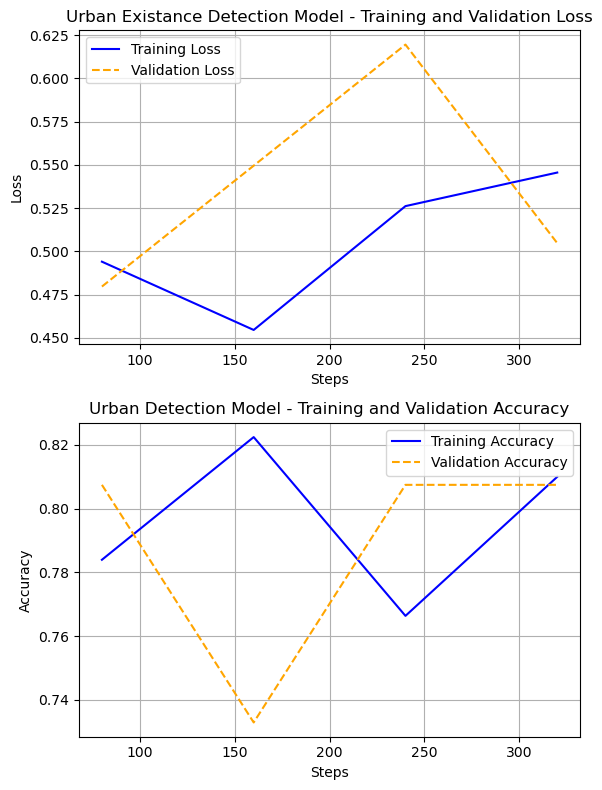

In [13]:
# Retrieving logged data
steps = custom_logging_callback.batches
batch_losses = custom_logging_callback.batch_losses
batch_accuracies = custom_logging_callback.batch_accuracies
batch_val_loss = custom_logging_callback.batch_val_loss
batch_val_accuracy = custom_logging_callback.batch_val_accuracy

# Determining the total number of batches in each epoch
batches_per_epoch = len(steps) // 3  

# Determining the starting index of the last epoch
start_index_last_epoch = batches_per_epoch * 2

# Retrieving the relevant logged data for the last epoch
last_epoch_steps = steps[start_index_last_epoch:]
last_epoch_batch_losses = batch_losses[start_index_last_epoch:]
last_epoch_batch_val_loss = batch_val_loss[start_index_last_epoch:]
last_epoch_batch_accuracies = batch_accuracies[start_index_last_epoch:]
last_epoch_batch_val_accuracy = batch_val_accuracy[start_index_last_epoch:]

# Creating lists to hold all data points
combined_steps = []
combined_losses = []
combined_val_losses = []
combined_accuracies = []
combined_val_accuracies = []

# Iterating over the steps, losses, and accuracies
for step, loss, accuracy in zip(last_epoch_steps, last_epoch_batch_losses, last_epoch_batch_accuracies):
    combined_steps.append(step)
    combined_losses.append(loss)
    combined_accuracies.append(accuracy)

# Iterating over the validation steps, losses, and accuracies
val_step_index = 0
for step, val_loss, val_accuracy in zip(last_epoch_steps, last_epoch_batch_val_loss, last_epoch_batch_val_accuracy):
    # Only including validation metrics at specified intervals
    if step % custom_logging_callback.val_log == 0:
        combined_val_losses.append(val_loss)
        combined_val_accuracies.append(val_accuracy)
    else:
        # Fill with None for steps where validation metrics are not logged
        combined_val_losses.append(None)
        combined_val_accuracies.append(None)

plt.figure(figsize=(6, 8))

# Plotting training and validation loss
plt.subplot(2, 1, 1)
plt.plot(combined_steps, combined_losses, label='Training Loss', color='blue')
plt.plot(combined_steps, combined_val_losses, label='Validation Loss', color='orange', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Urban Existance Detection Model - Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(combined_steps, combined_accuracies, label='Training Accuracy', color='blue')
plt.plot(combined_steps, combined_val_accuracies, label='Validation Accuracy', color='orange', linestyle='--')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Urban Detection Model - Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
model.save("UrbanFINAL.keras")